In [1]:
# In case you don't have kymatio package already installed.
#!pip install kymatio

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import torch
from kymatio.torch import Scattering1D
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from VoicesDataset import VoicesDataset # A class for data loading.
import decimal
from sklearn import svm
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [3]:
log_eps = 1e-8
# Total variation features:
def tv_feats(X,g):
    if g == 0:
      X = np.log(np.abs(X)+log_eps)
    else:
      X = np.power(np.abs(X)+log_eps, g)
    
    X = np.abs(np.diff(X))
    X = np.sum(X, axis=2)
    return X


def mean_coeffs(X,g):
    X = np.log(np.abs(X)+log_eps)
    media = np.mean(X, axis = 2)
    devstd = np.std(X, axis = 2)
    return media, devstd


# In case you want to normalize the coefficients like in
# [J. Anden & S.Mallat, "Deep Scattering Spectrum"].

def normalize_scattering(Sx, scattering):
  meta = scattering.meta()
  order0 = np.where(meta['order'] == 0)
  order1 = np.where(meta['order'] == 1)
  order2 = np.where(meta['order'] == 2)
  xi_1 = meta['xi'][order1][:,0]
  xi_2 = meta['xi'][order2][:,0]

  for i, xc in enumerate(xi_1):
    filt = order2[0]
    filt = filt[np.where(xi_2 == xc)]
    Sx[filt] =  Sx[filt]/(Sx[i]+1e-8)

  return Sx

In [4]:
def get_feature_vector(data, J, g):
    T = np.max(data.shape)
    scattering = Scattering1D(J, T, 1)

    meta = scattering.meta()
    order0 = np.where(meta['order'] == 0)
    order1 = np.where(meta['order'] == 1)
    order2 = np.where(meta['order'] == 2)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
      scattering.cuda()
      data = data.cuda()
    
    sx1 = scattering.forward(data)
    if use_cuda:
      sx1 = sx1.cpu()

    sx  = sx1.numpy()
    media, devstd = mean_coeffs(sx,g)
    sx = tv_feats(sx, g)

    media = media[:,np.concatenate((order0[0], order2[0]))]
    devstd = devstd[:,np.concatenate((order0[0], order2[0]))]
    sx = sx[:,np.concatenate((order0[0], order2[0]))]

    sx = np.concatenate((sx, media), axis=1)
    # sx = np.nan_to_num(sx)

    # To use PCA
    # pca = PCA()
    # pca.fit(sx)
    # var_exp = pca.explained_variance_ratio_
    # for i in range(len(var_exp)):
    #   if np.sum(var_exp[0:i+1]) > 0.99 :
    #     n_comp = i+1
    #     explained_var = np.sum(var_exp[0:i+1])
    #     break    
    # pdirs = pca.components_[0:n_comp]
    # sx = np.matmul(sx, np.transpose(pdirs))

    # print('Varianza Explicada: {}', explained_var)
    # print(pdirs.shape)
    # print(sx.shape)
    # print(np.matmul(sx, np.transpose(pdirs)).shape)
    # print(sx.shape)
    return sx

In [5]:
def prepare_data(data,labels):
    # Prepare signals for scattering tranform.
    labels = labels.transpose()
    data = data.transpose()
    data = torch.tensor(data)
    L = data.shape[1]
    # Chop signals
    T = 2 ** 14
    data = data[:, int(L / 2 - T / 2):int(L / 2 + T / 2)]
    data = data.contiguous()
    data = data.type(dtype=torch.float32)
    return data, labels

In [6]:
def hp_fun(X,y):
    """
    Feature extraction and clasification for hyperparameters estimation.
    Input:
      X: Data matrix, each column corresponds to one variable or feature.
      y: Label vector, each row corresponds to the label of the corresponding row in X.
      K: Number of folds for cross-validation, we use five-folds c-v for hp.
  
    Output:
      mean_acc: Mean accuracy for model selection.
    """
    K = 5 # Five-folds cross-validation for hyperparameters
    acc = np.zeros((K, 1))
    scaler = StandardScaler()  # Data normalization function
    model = svm.SVC(kernel='rbf') # SVM for clasification
    # Other models
    # model = KNeighborsClassifier(n_neighbors = 27, weights='distance')
    
    skf = model_selection.StratifiedKFold(n_splits=K)
    skf.get_n_splits(X) 
    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        # print(k)
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train.ravel())
        y_hat = model.predict(X_test)
        acc[k] = accuracy_score(y_test, y_hat)

    mean_acc = np.mean(acc)
    return mean_acc

In [7]:
# Load both datasets
# This is done using a class VoicesDataset that implements Dataset and DataLoader classes for future implementations on torch.
# Unzip the two .csv files with the signals before runing this.
ds = VoicesDataset("saar")
data_saar, labels_saar = ds[:]
data_saar, labels_saar = prepare_data(data_saar,labels_saar)
ds = VoicesDataset("meei")
data_meei, labels_meei = ds[:]
data_meei, labels_meei = prepare_data(data_meei,labels_meei)

# Parameters and hyperparameters array
fs = 25000.0
J = np.array([i for i in range(3,15)])
G = np.arange(0, 1.1, .1)

In [8]:
acc = np.zeros((len(J),len(G)))
use_cuda = torch.cuda.is_available()
if use_cuda:
  print('Using cuda...')
else:
  print('Not using cuda')

max_acc = 0  
for j in range(len(J)):
    for g in range(len(G)):
      X_meei = get_feature_vector(data_meei, J[j], G[g])
      X_saar = get_feature_vector(data_saar, J[j], G[g])
      
      # Partition data into hyperparameters determination and validation sets.
      X_val_meei, X_hp_meei, y_val_meei, y_hp_meei = model_selection.train_test_split(X_meei, labels_meei,
                                                                                      test_size=0.2, shuffle=True,
                                                                                      random_state = 0)
      X_val_saar, X_hp_saar, y_val_saar, y_hp_saar = model_selection.train_test_split(X_saar, labels_saar,
                                                                                      test_size=0.2, shuffle=True,
                                                                                      random_state = 0)
      X_hp = np.concatenate((X_hp_meei, X_hp_saar), axis=0)
      y_hp = np.concatenate((y_hp_meei, y_hp_saar), axis=0)
      acc[j,g] = hp_fun(X_hp, y_hp)

      # Save data and hp corresponding to the best results for latter.
      if acc[j,g] > max_acc:
        max_acc = acc[j,g]
        J_max = J[j]
        G_max = G[g]
        X_val_meei_max = X_val_meei
        y_val_meei_max = y_val_meei
        X_meei_max = X_meei
        X_val_saar_max = X_val_saar
        y_val_saar_max = y_val_saar
        X_saar_max = X_saar

hp_ind = np.where(acc == np.amax(acc))
print('J max = {}, g max = {}'.format(J_max, G_max))

Not using cuda


KeyboardInterrupt: 

In [104]:
def val_fun(X,y, Xc = None,yc = None):
    """
    Feature extraction and clasification for model validation.
    Input:
      X: Data matrix, each column corresponds to one variable or feature.
      y: Label vector, each row corresponds to the label of the corresponding row in X.
      K: Number of folds for cross-validation, we use five-folds c-v for hp.
      Xc: Alternative test set for cross-dataset trials.
      yc: Alternative test set's labels.
    Output:
      mean_acc: Mean accuracy for model selection.
    """
    K = 10 #folds for CV
    skf = model_selection.StratifiedKFold(n_splits=K)  
    acc = np.zeros((K,1))
    acc_cross = np.zeros((K,1))
    cm = np.zeros((3,3))
    cm_cross = np.zeros((3,3))

    scaler = StandardScaler()  # Data normalization function
    model = svm.SVC(kernel='rbf') # SVM for clasification
    # model = KNeighborsClassifier(n_neighbors = 27, weights='distance')
    skf.get_n_splits(X)

    results = pd.DataFrame( columns = ['Acc', 'Acc_Cross.'] +
                           ['cm_{}'.format(i) for i in range(9)] +
                           ['cm_cross{}'.format(i) for i in range(9)])

    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train.ravel())
        # print(1/X_train.shape[1]*X_train.var())
        y_hat = model.predict(X_test)

        if type(Xc) is np.ndarray:
          scaler.fit(Xc)
          Xc = scaler.transform(Xc)
          yc_hat = model.predict(Xc)
          acc_cross[k] = accuracy_score(yc, yc_hat)
          cm_cross = confusion_matrix(yc, yc_hat, normalize='true')

        acc[k] = accuracy_score(y_test, y_hat)
        cm = confusion_matrix(y_test, y_hat, normalize='true')
        results.head()
        results.loc[k] = ([acc[k,0], acc_cross[k,0]] + 
                          np.concatenate([i for i in cm]).tolist() + 
                          np.concatenate([i for i in cm_cross]).tolist())
                                
    mean_acc = np.mean(acc)

    if type(Xc) is np.ndarray:
      mean_acc_cross = np.mean(acc_cross)
      return mean_acc, results, mean_acc_cross
    else:
      return mean_acc, results

In [105]:
X_val = np.concatenate((X_val_meei_max, X_val_saar_max), axis=0)
y_val = np.concatenate((y_val_meei_max, y_val_saar_max), axis=0)
acc_val, results_general = val_fun(X_val, y_val)
acc_meei, results_meei, acc_cross_saar = val_fun(X_val_meei_max, y_val_meei_max, X_saar_max, labels_saar)
acc_saar, results_saar, acc_cross_meei = val_fun(X_val_saar_max, y_val_saar_max, X_meei_max, labels_meei)

# Save results in .csv files.
results_general.to_csv('/content/gdrive/MyDrive/scatter_signal_typing/results_general.csv')
results_meei.to_csv('/content/gdrive/MyDrive/scatter_signal_typing/results_meei.csv')
results_saar.to_csv('/content/gdrive/MyDrive/scatter_signal_typing/results_saar.csv')

print('Overall Accuracy: {}'.format(acc_val))
print('Overall Accuracy MEEI: {}'.format(acc_meei))
print('Overall Accuracy Cross-SAAR: {}'.format(acc_cross_saar))
print('Overall Accuracy SAAR: {}'.format(acc_saar))
print('Overall Accuracy Cross-MEEI: {}'.format(acc_cross_meei))

Overall Accuracy: 0.8374851485148515
Overall Accuracy MEEI: 0.8437782805429865
Overall Accuracy Cross-SAAR: 0.8370309951060358
Overall Accuracy SAAR: 0.8306122448979592
Overall Accuracy Cross-MEEI: 0.8135593220338982


In [106]:
def figure_conf_matrix(cm, sdm, title, size_inches = (3.5,3.5), file_path = None):
  # If you enter file_path, the image is saved there.

  group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()]

  group_percentages2 = ["{0:.2%}".format(value) for value in sdm.flatten()]

  labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_percentages, group_percentages2)]
  labels = np.asarray(labels).reshape(3,3)
  

  fig = plt.figure()
  disp = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
                     cbar= False, annot_kws={"size": 14})
  disp.xaxis.set_ticklabels(['Type 1', 'Type 2', 'Type 3'],
                            fontsize = 13, horizontalalignment='center')
  disp.yaxis.set_ticklabels(['Type 1', 'Type 2', 'Type 3'],
                            fontsize = 13, verticalalignment='center')
  disp.set_xlabel('Predicted Class', fontsize = 13)
  disp.xaxis.set_label_position('top') 
  disp.xaxis.tick_top()
  disp.set_ylabel('True class', fontsize = 13)
  fig.set_size_inches(size_inches)
  if file_path is not None:
    plt.title(title, fontsize = 15)
    plt.savefig(filename +'.pdf',bbox_inches='tight')# , format='svg')

Overall Accuracy = 83.74851485148514 (4.534455008844242)


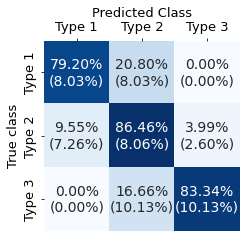

In [107]:
acc = results_general['Acc'].to_numpy()
print('Overall Accuracy = {} ({})'.format(np.mean(acc)*100,np.std(acc)*100))

cm = results_general.loc[:,'cm_0':'cm_8'].to_numpy()
sdcm = np.std(cm,axis = 0)
cm = np.mean(cm,axis = 0)

cm = cm.reshape((3,3))
title = 'Train and Test: MEEI + SVD'
figure_conf_matrix(cm, sdcm, title)

MEEI Accuracy = 84.37782805429865 (4.06971065165452)
Cross SAAR Accuracy = 83.70309951060358 (0.4091333182376658)


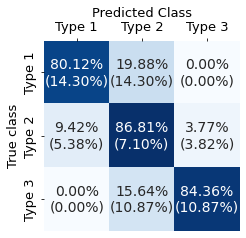

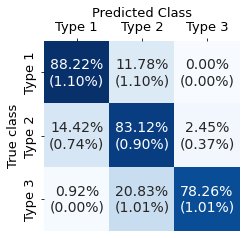

In [108]:
acc = results_meei['Acc'].to_numpy()
print('MEEI Accuracy = {} ({})'.format(np.mean(acc)*100,np.std(acc)*100))
acc_cross = results_meei['Acc_Cross.'].to_numpy()
print('Cross SAAR Accuracy = {} ({})'.format(np.mean(acc_cross)*100,np.std(acc_cross)*100))

cm = results_meei.loc[:,'cm_0':'cm_8'].to_numpy()
sdcm = np.std(cm,axis = 0)
cm = np.mean(cm,axis = 0)
cm = cm.reshape((3,3))
title = 'Train: MEEI - Test: MEEI'
figure_conf_matrix(cm, sdcm, title)

cm = results_meei.loc[:,'cm_cross0':'cm_cross8'].to_numpy()
sdcm = np.std(cm,axis = 0)
cm = np.mean(cm,axis = 0)
cm = cm.reshape((3,3))
title = 'Train: MEEI - Test: SVD'
figure_conf_matrix(cm, sdcm, title)

SAAR Accuracy = 83.06122448979592 (7.747041998409106)
Cross MEEI Accuracy = 81.35593220338983 (0.8578989773235792)


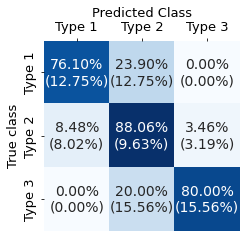

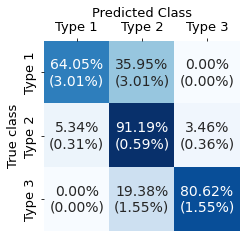

In [109]:
acc = results_saar['Acc'].to_numpy()
print('SAAR Accuracy = {} ({})'.format(np.mean(acc)*100,np.std(acc)*100))
acc_cross = results_saar['Acc_Cross.'].to_numpy()
print('Cross MEEI Accuracy = {} ({})'.format(np.mean(acc_cross)*100,np.std(acc_cross)*100))


cm = results_saar.loc[:,'cm_0':'cm_8'].to_numpy()
sdcm = np.std(cm,axis = 0)
cm = np.mean(cm,axis = 0)
cm = cm.reshape((3,3))
filename = file_path + 'cm_results_saar'
title = 'Train: SVD - Test: SVD'
figure_conf_matrix(cm, sdcm, title)

cm = results_saar.loc[:,'cm_cross0':'cm_cross8'].to_numpy()
sdcm = np.std(cm,axis = 0)
cm = np.mean(cm,axis = 0)
cm = cm.reshape((3,3))
title = 'Train: SVD - Test: MEEI'
figure_conf_matrix(cm, sdcm, title)